In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
from collections import defaultdict

In [2]:
import xgboost as xgb

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from src.apis import load_awos_by_point, load_ec_by_airport, load_wrf_by_airport
from src.model_opt import get_best_params_by_bo

In [5]:
airport = 'ZBAA'

In [6]:
site = '18L'

In [127]:
start_time = datetime(2018, 3, 2)
end_time = datetime(2019, 4, 30)

In [128]:
df_ec = load_ec_by_airport(site, start_time-timedelta(hours=12), end_time-timedelta(hours=12), start_point=12)

In [79]:
# df_wrf = load_wrf_by_airport(site, start_time-timedelta(hours=12), end_time-timedelta(hours=12), start_point=12)

In [129]:
df_ec.shape, df_wrf.shape

((424, 252), (179, 252))

In [130]:
obs_df = load_awos_by_point(airport, site, start_time - timedelta(days=1), end_time=end_time - timedelta(days=1))

In [131]:
def pivot_arr_by_date(arr, tag):
    meta_df = arr.to_frame(name='obs')
    meta_df['date'] = arr.index.floor('d')
    meta_df['hour'] = arr.index.hour
    new_df = meta_df.pivot(columns='hour', index='date', values='obs')
    yesterday_df = new_df.copy()
    yesterday_df.index = yesterday_df.index + timedelta(days=1)
    yesterday_df.columns = [x - 24 for x in yesterday_df.columns]
    obs_mat = pd.concat([yesterday_df, new_df], axis=1)
    obs_mat.columns = [f'obs_{tag}.{x}' for x in obs_mat.columns]
    return obs_mat

In [132]:
obs_ws_mat = pivot_arr_by_date(obs_df['obs_ws'], 'ws')

In [133]:
# raw_data = pd.concat([obs_ws_mat, df_wrf], axis=1)
# raw_data = raw_data.loc[df_wrf.index]

In [134]:
raw_data = pd.concat([obs_ws_mat, df_ec], axis=1)
raw_data = raw_data.loc[df_ec.index]

### 特征加工

In [135]:
# 风速，湿球温度与气温差值，预报风速误差
for idx in range(-12, 24):
    raw_data[f'rh_delta.{idx}'] = raw_data[f'T2.{idx}'] - raw_data[f'TD2.{idx}']
    raw_data[f'bias.{idx}'] = raw_data[f'obs_ws.{idx}'] - raw_data[f'SPD10.{idx}']

In [136]:
# 气压变，温度变，风速变
for idx in range(0, 24):
    for span in (1, 3, 6, 12):
        raw_data[f'PSFC_{span}d.{idx}'] = raw_data[f'PSFC.{idx}'] - raw_data[f'PSFC.{idx-span}']
        raw_data[f'T2_{span}d.{idx}'] = raw_data[f'T2.{idx}'] - raw_data[f'T2.{idx-span}']
        raw_data[f'SPD10_{span}d.{idx}'] = raw_data[f'SPD10.{idx}'] - raw_data[f'SPD10.{idx-span}']

### 训练模型

In [137]:
def rmse(y_arr):
    return np.sqrt((y_arr ** 2).mean())

In [138]:
def get_dataset(raw_data, fc_hr, is_train, is_eval, is_test):
    feat_list = [f'U10.{x}' for x in range(-12, 24)] + [f'V10.{x}' for x in range(-12, 24)] + \
        [f'bias.{x}' for x in range(-12, 0)] + [f'SPD10.{x}' for x in range(-12, 24)] + \
        [f'rh_delta.{x}' for x in range(-12, 24)] + \
        [f'PSFC_{span}d.{fc_hr}' for span in (1, 3, 6, 12)] + [f'T2_{span}d.{fc_hr}' for span in (1, 3, 6, 12)] + \
        [f'SPD10_{span}d.{fc_hr}' for span in (1, 3, 6, 12)]
    x_train = raw_data.loc[is_train, feat_list].copy()
    y_train = raw_data.loc[is_train, f'bias.{fc_hr}'].copy()
    is_valid = y_train.notnull()
    x_train = x_train.loc[is_valid]
    y_train = y_train.loc[is_valid]
    x_eval = raw_data.loc[is_eval, feat_list].copy()
    y_eval = raw_data.loc[is_eval, f'bias.{fc_hr}'].copy()
    is_valid = y_eval.notnull()
    x_eval = x_eval.loc[is_valid]
    y_eval = y_eval.loc[is_valid]
    x_test = raw_data.loc[is_test, feat_list].copy()
    y_test = raw_data.loc[is_test, f'bias.{fc_hr}'].copy()
    return x_train, y_train, x_eval, y_eval, x_test, y_test

In [139]:
is_train = raw_data.index < datetime(2019, 3, 1)
is_eval = (raw_data.index >= datetime(2019, 3, 1)) & (raw_data.index < datetime(2019, 4, 1))
is_test = raw_data.index >= datetime(2019, 4, 1)

In [140]:
is_train.sum(), is_eval.sum(), is_test.sum()

(364, 31, 29)

In [154]:
clf.best_iteration

112

In [156]:
pred_list = []
for fc_hr in range(0, 24):
    print(f'Hour: {fc_hr}')
    x_train, y_train, x_eval, y_eval, x_test, y_test = get_dataset(raw_data, fc_hr, is_train, is_eval, is_test)
    clf = xgb.XGBRegressor(booster='gbtree', learning_rate=0.04, n_estimators=300, verbosity=0, n_jobs=16, seed=42,
                           reg_alpha=0.1, reg_lambda=0.1, colsample_bytree=0.6, max_depth=6, subsample=0.5)
    clf.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], eval_metric='rmse', early_stopping_rounds=20, verbose=0)
    best_n = clf.best_iteration
    clf = xgb.XGBRegressor(booster='gbtree', learning_rate=0.04, n_estimators=best_n, verbosity=0, n_jobs=16, seed=42,
                           reg_alpha=0.1, reg_lambda=0.1, colsample_bytree=0.6, max_depth=6, subsample=0.5)
    clf.fit(pd.concat([x_train, x_eval]), pd.concat([y_train, y_eval]), verbose=0)
    yhat = clf.predict(x_test)
    yhat = pd.Series(yhat, index=x_test.index)
    pred_one = yhat + x_test[f'SPD10.{fc_hr}']
    pred_one.index = pred_one.index + timedelta(hours=fc_hr)
    pred_one.loc[pred_one < 0.52] = 0.52
    pred_list.append(pred_one)

Hour: 0
Hour: 1
Hour: 2
Hour: 3
Hour: 4
Hour: 5
Hour: 6
Hour: 7
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20
Hour: 21
Hour: 22
Hour: 23


In [157]:
result = pd.concat(pred_list).sort_index()
result = result.loc[result.notnull()]
result.loc[result<0.52] = 0.52

In [158]:
obs_true = obs_df.loc[result.index, 'obs_ws']

In [159]:
ws_ec = x_test[[f'SPD10.{x}' for x in range(24)]]
ws_ec = pd.Series(ws_ec.values.reshape((-1,)), index=obs_true.index)

In [160]:
rmse(obs_true - ws_ec)

1.732786460739214

In [161]:
rmse(obs_true - result)

1.392863967803269

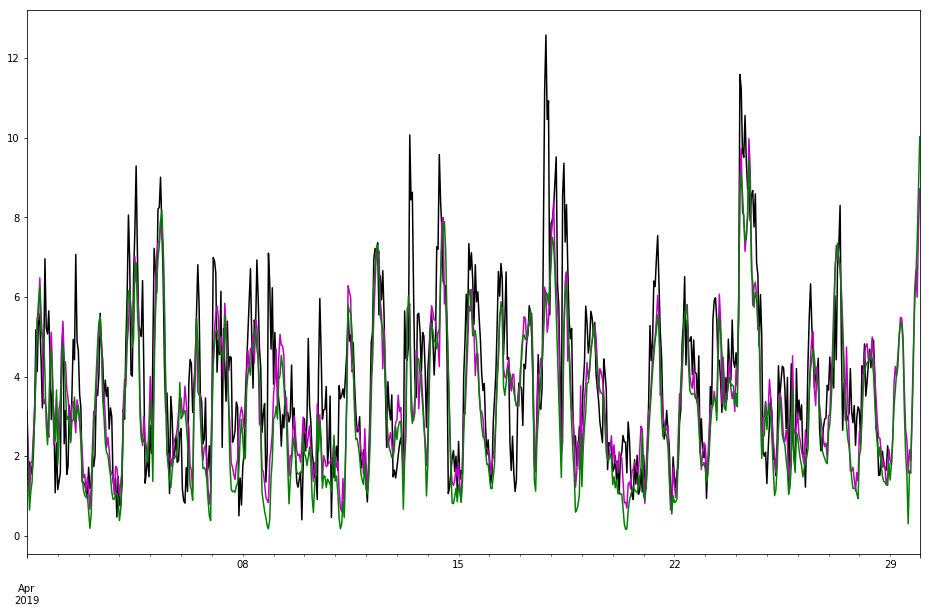

In [112]:
plt.rcParams['figure.figsize'] = 16, 10
obs_true.plot(color='k')
result.plot(color = 'm')
ws_ec.plot(color = 'g')